Here, we redefine the aimc value based on the original Park & Choi (2005) definition of the early type galaxies in the color - color-gradient space:

\begin{equation}
  \text{aimc} = \tan^{-1} \left( \frac{-\Delta (g-i) + 0.3}{(u-r) - 1} \right) + 90^\circ
\end{equation}

We also redefine the $c_{inv}$ cut based on skew-normal fits to the $c_{inv}$ distributions for each magnitude bin.

And, we redefine the $u - r$ cut between blue early types and normal early types based on skew-normal fits to the $u - r$ distributions for each magnitude bin.

In [171]:
from astropy.table import Table, vstack, join

import numpy as np

from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data import

In [2]:
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
galaxy_filename = '/Users/kellydouglass/Documents/Research/data/NSA_v1_0_1_VAGC.fits'

#galaxies = Table.read(galaxy_filename, format='ascii.commented_header')
galaxies = Table.read(galaxy_filename, format='fits')

## Replace all invalid colors, color gradients with NaNs

In [3]:
galaxies['cd'][galaxies['cd'] == -99] = np.nan
galaxies['u_r_KIAS'][galaxies['u_r_KIAS'] == -99] = np.nan

# Calculate aimc

In [4]:
def my_aimc_vertical(grad, color):
    
    grad_shift = 0.3
    color_shift = -1
    
    aimc = np.arctan2(-grad + grad_shift, color + color_shift) + 0.5*np.pi
    
    # Need to convert from radians to degrees
    aimc = aimc*180/np.pi
    
    # Need to map [-180,0) to [180,360)
    aimc[aimc < 0] += 360
    
    return aimc

In [5]:
galaxies['my_aimc'] = my_aimc_vertical(galaxies['cd'], galaxies['u_r_KIAS'])

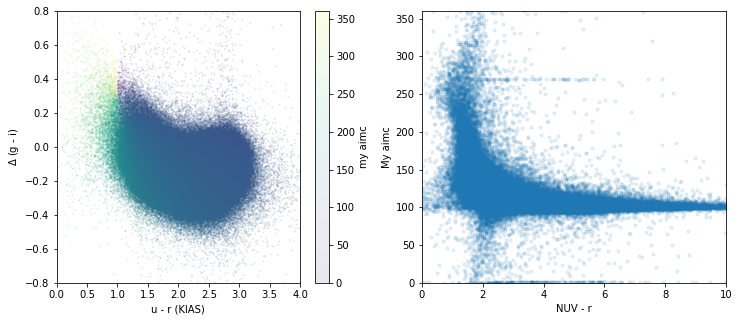

In [6]:
plt.figure(figsize=(12,5))



plt.subplot(121)

plt.scatter(galaxies['u_r_KIAS'], galaxies['cd'], s=1, c=galaxies['my_aimc'], alpha=0.1)

cbar = plt.colorbar()
cbar.ax.set_ylabel('my aimc')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

plt.axis([0, 4, -0.8, 0.8])



plt.subplot(122)

plt.plot(galaxies['NUV_r'], galaxies['my_aimc'], '.', alpha=0.1)

#plt.hlines([45, 275], 0, 10, colors='r', linestyle='dotted')

#plt.vlines(5, 0, 165, colors='g', linestyle='dashed')

plt.axis([0, 10, 0, 360])

plt.xlabel('NUV - r')
plt.ylabel('My aimc');

# Define the GV

Split the galaxies up based on their location in the color - color gradient space (based on a modified version of that presented in Park & Choi 2005 and Choi et al. 2010), their inverse concentration index, and their `my_aimc_vertical` value.

* RS: normal early-type galaxies
* GV: 
  * blue early-type galaxies
  * normal late-type galaxies within the bounds of early-types with `conx1` > some value
  * normal late-type galaxies with `my_aimc` < 110
* BC: normal late-type galaxies with `my_aimc` > 110

#### Magnitude bins

In [7]:
boolean_14p5_16 = galaxies['prmag'] < 16
boolean_16_16p5 = np.logical_and(galaxies['prmag'] >= 16, galaxies['prmag'] < 16.5)
boolean_16p5_17 = np.logical_and(galaxies['prmag'] >= 16.5, galaxies['prmag'] < 17)
boolean_17_17p5 = galaxies['prmag'] >= 17

### Define the `conx1` limit as the intersection of the skew-normal distribution sum

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [8]:
from skewNorms_fit import skewNorms2, skewNorms2_fit, skewNorms2_diff

from scipy.stats import skewnorm

In [9]:
cinv_bins = np.arange(0.2, 0.6, 0.005)
cinv_centers = 0.5*(cinv_bins[1:] + cinv_bins[:-1])

##### Brightest galaxies

In [38]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16], bins=cinv_bins)

cinv_bestfit = skewNorms2_fit(cinv_centers, dist_bright, param_bounds)

print(cinv_bestfit)

      fun: 482.4297264388559
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52650607e-04, -5.96401151e-01,  3.70607722e-01, -1.53477232e-03,
       -2.55795182e-04,  1.83405290e-01, -1.11486997e-01,  1.77351468e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2187
      nit: 171
     njev: 243
   status: 0
  success: True
        x: array([ 1.67289034e+02,  2.90195135e-01,  5.05804183e-02,  5.30649404e+00,
        1.61267893e+02,  5.07802297e-01,  8.55862065e-02, -2.12272477e+00])


##### $16 < m_r < 16.5$

In [39]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5], bins=cinv_bins)

cinv_bestfit_16_16p5 = skewNorms2_fit(cinv_centers, dist_16_16p5, param_bounds)

print(cinv_bestfit_16_16p5)

      fun: 423.09101638660604
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.30739760e-03,  3.41560735e-01, -1.47724677e-01,  1.36424206e-04,
        1.01181205e-03,  4.36813250e-01, -1.46417278e-01,  3.17186279e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1683
      nit: 94
     njev: 187
   status: 0
  success: True
        x: array([ 1.61873347e+02,  2.93497595e-01,  5.71403932e-02,  5.71130709e+00,
        1.43937436e+02,  5.10641606e-01,  8.03038270e-02, -2.10360904e+00])


##### $16.5 < m_r < 17$

In [40]:
param_bounds_16p5_17 = [[10., 3000.], # a ......... skew normal 1 amplitude
                        [0.25, 0.35], # mu_a ...... skew normal 1 mean
                        [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                        [-30., 30.],  # skew_a .... skew normal 1 skew
                        [1., 1000.],  # b ......... skew normal 2 amplitude
                        [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                        [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                        [0., 20.]]    # skew_b .... skew normal 2 skew

dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17], bins=cinv_bins)

cinv_bestfit_16p5_17 = skewNorms2_fit(cinv_centers, dist_16p5_17, param_bounds_16p5_17)

print(cinv_bestfit_16p5_17)

      fun: 748.6066794036079
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.40971567e-03, -2.26071961e+00, -3.90969035e-02, -8.68567445e-03,
        1.58024579e-03,  1.45105332e+00, -1.12589760e+00,  4.75438355e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1494
      nit: 111
     njev: 166
   status: 0
  success: True
        x: array([3.25092785e+02, 2.97944592e-01, 7.16962987e-02, 5.27256774e+00,
       2.05393843e+02, 4.70910308e-01, 4.32689688e-02, 5.81715837e-04])


##### Faint galaxies

In [41]:
param_bounds_faint = [[10., 3000.], # a ......... skew normal 1 amplitude
                      [0.25, 0.4],  # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                      [-30., 30.],  # skew_a .... skew normal 1 skew
                      [1., 1000.],  # b ......... skew normal 2 amplitude
                      [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                      [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5], bins=cinv_bins)

cinv_bestfit_faint = skewNorms2_fit(cinv_centers, dist_faint, param_bounds_faint)

print(cinv_bestfit_faint)

      fun: 387.37302022655285
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.11590364e-03,  8.08818755e+00, -5.83914926e+00,  2.00884643e-02,
       -9.66337354e-04, -1.46346166e+01,  3.07937853e+00, -6.18740618e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1179
      nit: 90
     njev: 131
   status: 0
  success: True
        x: array([ 7.56153172e+02,  3.06070702e-01,  8.02282244e-02,  5.15753154e+00,
        6.00794680e+02,  5.18455571e-01,  7.76548456e-02, -2.40256943e+00])


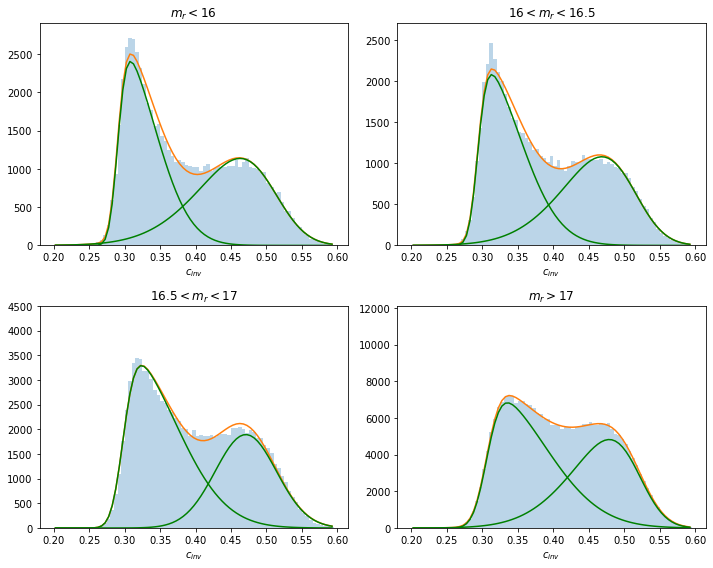

In [42]:
plt.figure(figsize=(10,8), tight_layout=True)

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['conx1'][boolean_14p5_16], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(cinv_bestfit.x, cinv_centers))
plt.plot(cinv_centers, 
         cinv_bestfit.x[0]*skewnorm.pdf(cinv_centers, 
                                        cinv_bestfit.x[3], 
                                        loc=cinv_bestfit.x[1], 
                                        scale=cinv_bestfit.x[2]), 
        'g')
plt.plot(cinv_centers,
         cinv_bestfit.x[4]*skewnorm.pdf(cinv_centers, 
                                        cinv_bestfit.x[7], 
                                        loc=cinv_bestfit.x[5], 
                                        scale=cinv_bestfit.x[6]), 
        'g')

plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['conx1'][boolean_16_16p5], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(cinv_bestfit_16_16p5.x, cinv_centers))
plt.plot(cinv_centers, 
         cinv_bestfit_16_16p5.x[0]*skewnorm.pdf(cinv_centers, 
                                                cinv_bestfit_16_16p5.x[3], 
                                                loc=cinv_bestfit_16_16p5.x[1], 
                                                scale=cinv_bestfit_16_16p5.x[2]), 
        'g')
plt.plot(cinv_centers,
         cinv_bestfit_16_16p5.x[4]*skewnorm.pdf(cinv_centers, 
                                                cinv_bestfit_16_16p5.x[7], 
                                                loc=cinv_bestfit_16_16p5.x[5], 
                                                scale=cinv_bestfit_16_16p5.x[6]), 
        'g')

plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['conx1'][boolean_16p5_17], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(cinv_bestfit_16p5_17.x, cinv_centers))
plt.plot(cinv_centers, 
         cinv_bestfit_16p5_17.x[0]*skewnorm.pdf(cinv_centers, 
                                                cinv_bestfit_16p5_17.x[3], 
                                                loc=cinv_bestfit_16p5_17.x[1], 
                                                scale=cinv_bestfit_16p5_17.x[2]), 
        'g')
plt.plot(cinv_centers,
         cinv_bestfit_16p5_17.x[4]*skewnorm.pdf(cinv_centers, 
                                                cinv_bestfit_16p5_17.x[7], 
                                                loc=cinv_bestfit_16p5_17.x[5], 
                                                scale=cinv_bestfit_16p5_17.x[6]), 
        'g')

plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['conx1'][boolean_17_17p5],
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(cinv_bestfit_faint.x, cinv_centers))
plt.plot(cinv_centers, 
         cinv_bestfit_faint.x[0]*skewnorm.pdf(cinv_centers, 
                                              cinv_bestfit_faint.x[3], 
                                              loc=cinv_bestfit_faint.x[1], 
                                              scale=cinv_bestfit_faint.x[2]), 
        'g')
plt.plot(cinv_centers,
         cinv_bestfit_faint.x[4]*skewnorm.pdf(cinv_centers, 
                                              cinv_bestfit_faint.x[7], 
                                              loc=cinv_bestfit_faint.x[5], 
                                              scale=cinv_bestfit_faint.x[6]), 
        'g')

plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$');
################################################################################

### $c_\text{inv}$ cut

We implement a cut on $c_\text{inv}$ to filter normal early-type galaxies from normal late-type galaxies which fall within the Park05 bounds defining normal early-type galaxies.

Instead of using fixed values (based on magnitude bins) as done in Park05, we will use the point of intersection between the two skew normal functions fit to the data.

In [15]:
from scipy.optimize import root_scalar

##### Bright galaxies

In [43]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=cinv_bestfit.x, 
                          bracket=[0.35, 0.45], 
                          x0=(cinv_bestfit.x[1] + 2*cinv_bestfit.x[2]))

print(rootResults)

cinv_bright = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3819366684461545


##### $16 < m_r < 16.5$

In [44]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=cinv_bestfit_16_16p5.x, 
                          bracket=[0.35, 0.45], 
                          x0=(cinv_bestfit_16_16p5.x[1] + 2*cinv_bestfit_16_16p5.x[2]))

print(rootResults)

cinv_16_16p5 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.39332147665218115


##### $16.5 < m_r < 17$

In [45]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=cinv_bestfit_16p5_17.x, 
                          bracket=[0.35, 0.45], 
                          x0=(cinv_bestfit_16p5_17.x[1] + 2*cinv_bestfit_16p5_17.x[2]))

print(rootResults)

cinv_16p5_17 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.41787545128339787


##### Faint galaxies

In [46]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=cinv_bestfit_faint.x, 
                          bracket=[0.35, 0.45], 
                          x0=(cinv_bestfit_faint.x[1] + 2*cinv_bestfit_faint.x[2]))

print(rootResults)

cinv_faint = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.4198228451026122


### Define the $u - r$ limit as the intersection of the skew-normal distribution sum

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [62]:
ur_bins = np.arange(0, 4, 0.01)
ur_centers = 0.5*(ur_bins[1:] + ur_bins[:-1])

##### Bright galaxies

In [65]:
param_bounds = [[100., 5000.], # a ......... skew normal 1 amplitude
                [0, 2.5],       # mu_a ...... skew normal 1 mean
                [0.01, 3.0],    # sigma_a ... skew normal 1 standard deviation
                [-5., 5.],      # skew_a .... skew normal 1 skew
                [100., 5000.], # b ......... skew normal 2 amplitude
                [2.5, 4],       # mu_b ...... skew normal 2 mean
                [0.01, 3.0],    # sigma_b ... skew normal 2 standard deviation
                [-5., 5.]]      # skew_b .... skew normal 2 skew

dist_bright,_ = np.histogram(galaxies['u_r_KIAS'][boolean_14p5_16], bins=ur_bins)

ur_bestfit = skewNorms2_fit(ur_centers, dist_bright, param_bounds)

print(ur_bestfit)

      fun: 1369.1099766174984
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.36424097e-04,  1.57206160e-01,  3.91673894e-01,  9.40190148e-02,
        1.43245302e-03, -1.96041584e-01, -9.95760275e-01, -2.14413377e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2484
      nit: 197
     njev: 276
   status: 0
  success: True
        x: array([ 3.40869153e+02,  2.23003660e+00,  4.97108301e-01, -4.12758692e-01,
        3.17602481e+02,  2.91582918e+00,  1.96884717e-01, -2.19692393e+00])


In [66]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=ur_bestfit.x, 
                          bracket=[1, 3], 
                          x0=(ur_bestfit.x[1] + 2*ur_bestfit.x[2]))

print(rootResults)

ur_bright = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 2.5275363025947524


##### $16 < m_r < 16.5$

In [70]:
param_bounds = [[100., 5000.], # a ......... skew normal 1 amplitude
                [0, 2.5],       # mu_a ...... skew normal 1 mean
                [0.01, 3.0],    # sigma_a ... skew normal 1 standard deviation
                [-20., 30.],      # skew_a .... skew normal 1 skew
                [100., 5000.], # b ......... skew normal 2 amplitude
                [2.5, 4],       # mu_b ...... skew normal 2 mean
                [0.01, 3.0],    # sigma_b ... skew normal 2 standard deviation
                [-20., 30.]]      # skew_b .... skew normal 2 skew

dist_16_16p5,_ = np.histogram(galaxies['u_r_KIAS'][boolean_16_16p5], bins=ur_bins)

ur_bestfit_16_16p5 = skewNorms2_fit(ur_centers, dist_16_16p5, param_bounds)

print(ur_bestfit_16_16p5)

      fun: 1420.787571849239
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00029559, -0.21930191,  0.05848051, -0.06934897, -0.00056843,
        0.27137048,  0.01375611,  0.00950422])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3636
      nit: 273
     njev: 404
   status: 0
  success: True
        x: array([ 3.34782033e+02,  1.71547832e+00,  5.62994967e-01,  8.69302901e-01,
        2.77867954e+02,  2.90832613e+00,  2.10183331e-01, -1.89105351e+00])


In [71]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=ur_bestfit_16_16p5.x, 
                          bracket=[1, 3], 
                          x0=(ur_bestfit_16_16p5.x[1] + 2*ur_bestfit_16_16p5.x[2]))

print(rootResults)

ur_16_16p5 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 2.499786092663622


##### $16.5 < m_r < 17$

In [75]:
param_bounds_16p5_17 = [[100., 8000.], # a ......... skew normal 1 amplitude
                        [0, 2.5],       # mu_a ...... skew normal 1 mean
                        [0.01, 3.0],    # sigma_a ... skew normal 1 standard deviation
                        [-5., 5.],      # skew_a .... skew normal 1 skew
                        [100., 8000.], # b ......... skew normal 2 amplitude
                        [2.5, 4],       # mu_b ...... skew normal 2 mean
                        [0.01, 3.0],    # sigma_b ... skew normal 2 standard deviation
                        [-5., 5.]]      # skew_b .... skew normal 2 skew

dist_16p5_17,_ = np.histogram(galaxies['u_r_KIAS'][boolean_16p5_17], bins=ur_bins)

ur_bestfit_16p5_17 = skewNorms2_fit(ur_centers, dist_16p5_17, param_bounds_16p5_17)

print(ur_bestfit_16p5_17)

      fun: 1727.877548488971
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.56887712e-03,  1.56137504e-01,  3.98699738e-01, -2.85808712e-02,
        1.11413013e-03,  1.39441455e+00, -3.45630724e-01,  6.34372558e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1152
      nit: 79
     njev: 128
   status: 0
  success: True
        x: array([ 6.14761323e+02,  1.58881035e+00,  6.05818725e-01,  1.25142168e+00,
        4.47561851e+02,  2.89470641e+00,  2.21935964e-01, -1.70177854e+00])


In [76]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=ur_bestfit_16p5_17.x, 
                          bracket=[1, 3], 
                          x0=(ur_bestfit_16p5_17.x[1] + 2*ur_bestfit_16p5_17.x[2]))

print(rootResults)

ur_16p5_17 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 2.474812675173203


##### Faint galaxies

In [79]:
param_bounds_faint = [[1000., 10000.], # a ......... skew normal 1 amplitude
                      [0, 2.5],       # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],    # sigma_a ... skew normal 1 standard deviation
                      [-5, 5],        # skew_a .... skew normal 1 skew
                      [500., 5000.], # b ......... skew normal 2 amplitude
                      [2.5, 4],       # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],    # sigma_b ... skew normal 2 standard deviation
                      [-5., 5.]]      # skew_b .... skew normal 2 skew

dist_faint,_ = np.histogram(galaxies['u_r_KIAS'][boolean_17_17p5], bins=ur_bins)

ur_bestfit_faint = skewNorms2_fit(ur_centers, dist_faint, param_bounds_faint)

print(ur_bestfit_faint)

      fun: 2538.30775283384
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.27603456e-04, -4.89853849e-01,  5.28734742e-01, -1.28648026e-01,
        1.04591808e-03, -1.16679076e+00,  1.41508281e+00,  1.77351468e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1854
      nit: 158
     njev: 206
   status: 0
  success: True
        x: array([ 1.72701060e+03,  1.41280656e+00,  6.90435482e-01,  1.96141590e+00,
        9.89688659e+02,  2.86270780e+00,  2.39660634e-01, -1.38952219e+00])


In [80]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=ur_bestfit_faint.x, 
                          bracket=[1, 3], 
                          x0=(ur_bestfit_faint.x[1] + 2*ur_bestfit_faint.x[2]))

print(rootResults)

ur_faint = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 2.4349925004858806


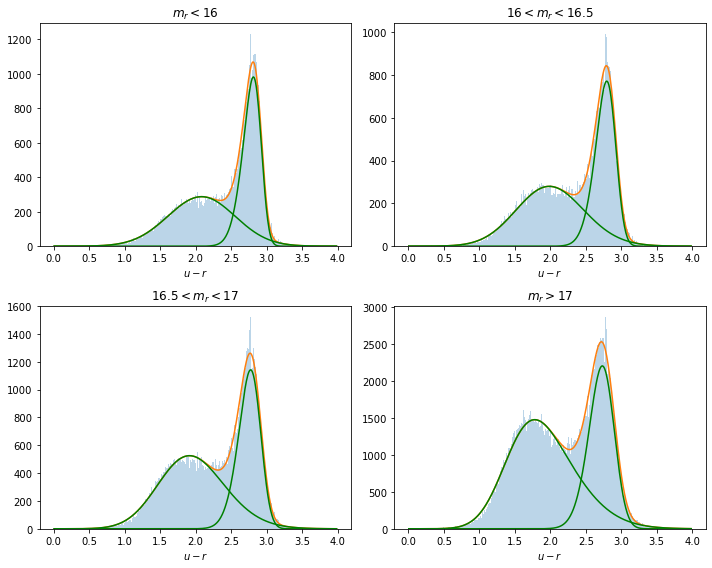

In [81]:
plt.figure(figsize=(10,8), tight_layout=True)

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['u_r_KIAS'][boolean_14p5_16], 
         bins=ur_bins, 
         alpha=0.3)

plt.plot(ur_centers, skewNorms2(ur_bestfit.x, ur_centers))
plt.plot(ur_centers, 
         ur_bestfit.x[0]*skewnorm.pdf(ur_centers, 
                                      ur_bestfit.x[3], 
                                      loc=ur_bestfit.x[1], 
                                      scale=ur_bestfit.x[2]), 
        'g')
plt.plot(ur_centers,
         ur_bestfit.x[4]*skewnorm.pdf(ur_centers, 
                                      ur_bestfit.x[7], 
                                      loc=ur_bestfit.x[5], 
                                      scale=ur_bestfit.x[6]), 
        'g')

#plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$u - r$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['u_r_KIAS'][boolean_16_16p5], 
         bins=ur_bins, 
         alpha=0.3)

plt.plot(ur_centers, skewNorms2(ur_bestfit_16_16p5.x, ur_centers))
plt.plot(ur_centers, 
         ur_bestfit_16_16p5.x[0]*skewnorm.pdf(ur_centers, 
                                              ur_bestfit_16_16p5.x[3], 
                                              loc=ur_bestfit_16_16p5.x[1], 
                                              scale=ur_bestfit_16_16p5.x[2]), 
        'g')
plt.plot(ur_centers,
         ur_bestfit_16_16p5.x[4]*skewnorm.pdf(ur_centers, 
                                              ur_bestfit_16_16p5.x[7], 
                                              loc=ur_bestfit_16_16p5.x[5], 
                                              scale=ur_bestfit_16_16p5.x[6]), 
        'g')

#plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$u - r$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['u_r_KIAS'][boolean_16p5_17], 
         bins=ur_bins, 
         alpha=0.3)

plt.plot(ur_centers, skewNorms2(ur_bestfit_16p5_17.x, ur_centers))
plt.plot(ur_centers, 
         ur_bestfit_16p5_17.x[0]*skewnorm.pdf(ur_centers, 
                                              ur_bestfit_16p5_17.x[3], 
                                              loc=ur_bestfit_16p5_17.x[1], 
                                              scale=ur_bestfit_16p5_17.x[2]), 
        'g')
plt.plot(ur_centers,
         ur_bestfit_16p5_17.x[4]*skewnorm.pdf(ur_centers, 
                                              ur_bestfit_16p5_17.x[7], 
                                              loc=ur_bestfit_16p5_17.x[5], 
                                              scale=ur_bestfit_16p5_17.x[6]), 
        'g')

#plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$u - r$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['u_r_KIAS'][boolean_17_17p5],
         bins=ur_bins, 
         alpha=0.3)

plt.plot(ur_centers, skewNorms2(ur_bestfit_faint.x, ur_centers))
plt.plot(ur_centers, 
         ur_bestfit_faint.x[0]*skewnorm.pdf(ur_centers, 
                                            ur_bestfit_faint.x[3], 
                                            loc=ur_bestfit_faint.x[1], 
                                            scale=ur_bestfit_faint.x[2]), 
        'g')
plt.plot(ur_centers,
         ur_bestfit_faint.x[4]*skewnorm.pdf(ur_centers, 
                                            ur_bestfit_faint.x[7], 
                                            loc=ur_bestfit_faint.x[5], 
                                            scale=ur_bestfit_faint.x[6]), 
        'g')

#plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$u - r$');
################################################################################

## Morphological class
Based on the morphological classification of Park & Choi (2005)

#### Early-type

In [82]:
early_boolean1 = np.logical_and(galaxies['u_r_KIAS'] > 1, galaxies['cd'] > 0.3)

early_boolean2_14p5_16 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1, 
                                                galaxies['u_r_KIAS'] <= 2.6, 
                                                galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))
early_boolean2_16_17 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                              galaxies['u_r_KIAS'] <= 2.65,
                                              galaxies['cd'] > -0.290909*galaxies['u_r_KIAS'] + 0.590909))
early_boolean2_17_17p5 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                                galaxies['u_r_KIAS'] <= 2.7,
                                                galaxies['cd'] > -0.28236*galaxies['u_r_KIAS'] + 0.582353))

early_boolean3_14p5_16 = np.logical_and(galaxies['u_r_KIAS'] > 2.60, galaxies['cd'] > -0.15)
early_boolean3_16_16p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, galaxies['cd'] > -0.18)
early_boolean3_16p5_17 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, 
                                        galaxies['cd'] > -(0.07/0.85)*galaxies['u_r_KIAS'] + (-0.25 + (0.07*3.5/0.85)))
early_boolean3_17_17p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.70, 
                                        galaxies['cd'] > -0.2125*galaxies['u_r_KIAS'] + 0.39375)

early_boolean_14p5_16_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_14p5_16, 
                                                   early_boolean3_14p5_16))
early_boolean_16_16p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16_16p5))
early_boolean_16p5_17_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16p5_17))
early_boolean_17_17p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_17_17p5, 
                                                   early_boolean3_17_17p5))

# Require early-type galaxies to have inverse concentration indices smaller 
# than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                       galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                       galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                       galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                       galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above 
# restriction on cinv (conx1) are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                    galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                    galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                    galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                    galaxies['conx1'] >= cinv_faint)

#### Late type

Note that these galaxies contain those already assigned to the GV.

In [83]:
late_boolean_14p5_16 = np.logical_not(early_boolean_14p5_16)
late_boolean_16_16p5 = np.logical_not(early_boolean_16_16p5)
late_boolean_16p5_17 = np.logical_not(early_boolean_16p5_17)
late_boolean_17_17p5 = np.logical_not(early_boolean_17_17p5)

In [88]:
early_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, early_boolean_14p5_16), 
                                               np.logical_and(boolean_16_16p5, early_boolean_16_16p5),
                                               np.logical_and(boolean_16p5_17, early_boolean_16p5_17),
                                               np.logical_and(boolean_17_17p5, early_boolean_17_17p5)))

late_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, late_boolean_14p5_16),
                                              np.logical_and(boolean_16_16p5, late_boolean_16_16p5),
                                              np.logical_and(boolean_16p5_17, late_boolean_16p5_17),
                                              np.logical_and(boolean_17_17p5, late_boolean_17_17p5)))

In [89]:
gv_early_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, gv_boolean_14p5_16), 
                                         np.logical_and(boolean_16_16p5, gv_boolean_16_16p5), 
                                         np.logical_and(boolean_16p5_17, gv_boolean_16p5_17), 
                                         np.logical_and(boolean_17_17p5, gv_boolean_17_17p5)))

## Morphologial type
Based on the classification by Choi et al. (2010)

#### Normal late type

In [90]:
normal_late_boolean1 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1.8,
                                              galaxies['u_r_KIAS'] < 3.5,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 0.5))
normal_late_boolean2 = np.logical_and.reduce((galaxies['u_r_KIAS'] <= 1.8,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 1))

normal_late_boolean = np.logical_and(late_galaxies_boolean, 
                                     np.logical_or(normal_late_boolean1, normal_late_boolean2))

In [91]:
gv_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] <= 110, 
                                                np.logical_not(gv_early_boolean)))

bc_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] > 110, 
                                                np.logical_not(gv_early_boolean)))

#### Normal early type

In [108]:
normal_early_boolean1 = np.logical_and.reduce((#galaxies['u_r_KIAS'] > 2.5,
                                               galaxies['u_r_KIAS'] < 3.5,
                                               galaxies['cd'] > -0.7, 
                                               galaxies['cd'] < 1))

normal_early_boolean_14p5_16 = np.logical_and.reduce((early_galaxies_boolean, 
                                                      normal_early_boolean1, 
                                                      galaxies['u_r_KIAS'] > ur_bright, 
                                                      boolean_14p5_16))
normal_early_boolean_16_16p5 = np.logical_and.reduce((early_galaxies_boolean, 
                                                      normal_early_boolean1, 
                                                      galaxies['u_r_KIAS'] > ur_16_16p5, 
                                                      boolean_16_16p5))
normal_early_boolean_16p5_17 = np.logical_and.reduce((early_galaxies_boolean, 
                                                      normal_early_boolean1, 
                                                      galaxies['u_r_KIAS'] > ur_16p5_17, 
                                                      boolean_16p5_17))
normal_early_boolean_17_17p5 = np.logical_and.reduce((early_galaxies_boolean, 
                                                      normal_early_boolean1, 
                                                      galaxies['u_r_KIAS'] > ur_faint, 
                                                      boolean_17_17p5))

normal_early_boolean = np.logical_or.reduce((normal_early_boolean_14p5_16, 
                                             normal_early_boolean_16_16p5, 
                                             normal_early_boolean_16p5_17, 
                                             normal_early_boolean_17_17p5))

#### Blue early type

In [109]:
blue_early_boolean1 = np.logical_and.reduce((#galaxies['u_r_KIAS'] < 2.5,
                                             galaxies['cd'] > -0.7,
                                             galaxies['cd'] < 1))

blue_early_boolean_14p5_16 = np.logical_and.reduce((early_galaxies_boolean, 
                                                    blue_early_boolean1, 
                                                    galaxies['u_r_KIAS'] < ur_bright, 
                                                    boolean_14p5_16))
blue_early_boolean_16_16p5 = np.logical_and.reduce((early_galaxies_boolean, 
                                                    blue_early_boolean1, 
                                                    galaxies['u_r_KIAS'] < ur_16_16p5, 
                                                    boolean_16_16p5))
blue_early_boolean_16p5_17 = np.logical_and.reduce((early_galaxies_boolean, 
                                                    blue_early_boolean1, 
                                                    galaxies['u_r_KIAS'] < ur_16p5_17, 
                                                    boolean_16p5_17))
blue_early_boolean_17_17p5 = np.logical_and.reduce((early_galaxies_boolean, 
                                                    blue_early_boolean1, 
                                                    galaxies['u_r_KIAS'] < ur_faint, 
                                                    boolean_17_17p5))

blue_early_boolean = np.logical_or.reduce((blue_early_boolean_14p5_16, 
                                           blue_early_boolean_16_16p5, 
                                           blue_early_boolean_16p5_17, 
                                           blue_early_boolean_17_17p5))

In [110]:
normal_late_galaxies = galaxies[normal_late_boolean]
normal_early_galaxies = galaxies[normal_early_boolean]
blue_early_galaxies = galaxies[blue_early_boolean]

In [111]:
RS_galaxies = galaxies[normal_early_boolean]

GV_galaxies = vstack([blue_early_galaxies, 
                      galaxies[gv_early_boolean], 
                      galaxies[gv_normal_late_boolean]])

BC_galaxies = galaxies[bc_normal_late_boolean]

Check to make sure that there are no galaxies in more than one category.

In [112]:
################################################################################
# RS - GV overlap
#-------------------------------------------------------------------------------
rs_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in RS_galaxies['index']:
        rs_gv_overlap += 1
    
print('Overlap between RS and GV:', rs_gv_overlap)
################################################################################

Overlap between RS and GV: 0


In [113]:
################################################################################
# RS - BC overlap
#-------------------------------------------------------------------------------
rs_bc_overlap = 0

for i in range(len(RS_galaxies)):
    if RS_galaxies['index'][i] in BC_galaxies['index']:
        rs_bc_overlap += 1
    
print('Overlap between RS and BC:', rs_bc_overlap)
################################################################################

Overlap between RS and BC: 0


In [114]:
################################################################################
# BC - GV overlap
#-------------------------------------------------------------------------------
bc_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in BC_galaxies['index']:
        bc_gv_overlap += 1
    
print('Overlap between BC and GV:', bc_gv_overlap)
################################################################################

Overlap between BC and GV: 0


# Color distribution

In [115]:
ur_bins = np.linspace(0,4.5,100)
NUVr_bins = np.linspace(0,10,100)

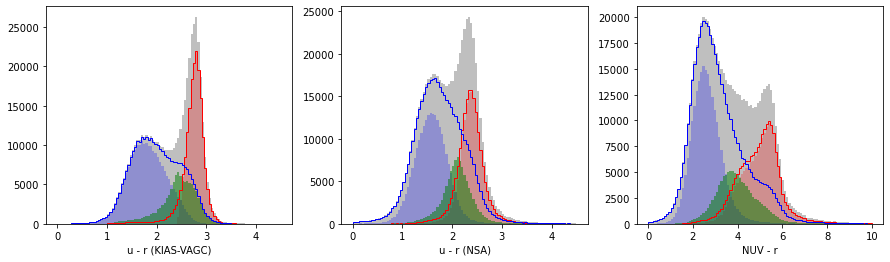

In [116]:
plt.figure(figsize=(15,4))

plt.subplot(131)

plt.hist(galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')




plt.subplot(132)

plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')




plt.subplot(133)

plt.hist(galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean], bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r');

There is a strange discontinuity in the GV population at $u - r = 2.5$.  It is most apparent in the KIAS-VAGC $u-r$ distribution, not the $u-r$ in the NSA.  This corresponds to a sharp cut in the RS at $u-r = 2.5$ as well, and is a result of the criteria separating the blue early types from the normal early types.

8/10/22: There is still a blue "bump" in the RS distribution in (NUV - r).  Is it becasue there are too many galaxies that have been shifted from the RS to the GV, or have not enough been moved from the RS to the GV?

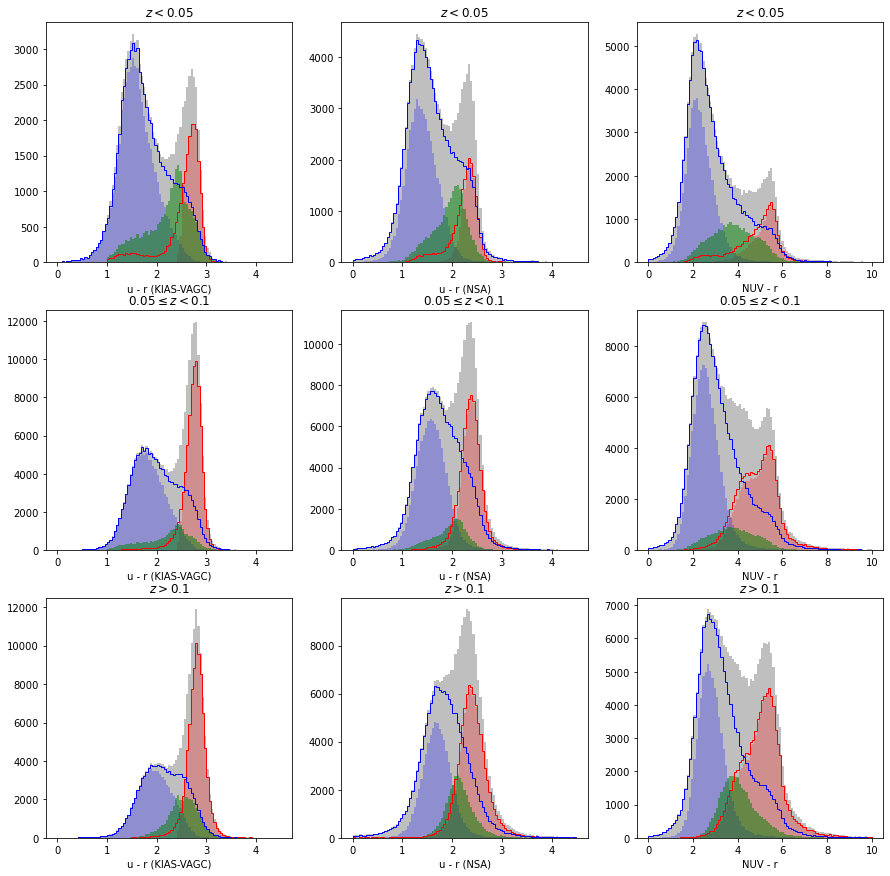

In [117]:
plt.figure(figsize=(15,15))

plt.subplot(331)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z < 0.05$')




plt.subplot(332)

plt.hist(galaxies['u_r'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z < 0.05$')




plt.subplot(333)

plt.hist(galaxies['NUV_r'][galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] < 0.05], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z < 0.05$')




plt.subplot(334)

plt.hist(galaxies['u_r_KIAS'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(335)

plt.hist(galaxies['u_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(336)

plt.hist(galaxies['NUV_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(337)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] >= 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z > 0.1$')




plt.subplot(338)

plt.hist(galaxies['u_r'][galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] > 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z > 0.1$')




plt.subplot(339)

plt.hist(galaxies['NUV_r'][galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] > 0.1], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z > 0.1$');

For $z < 0.05$, it looks like the GV is a little too wide $\to$ change where `aimc` is defined from?

For $0.05 \leq z < 0.1$, the blue bump in the RS is **very** apparent.  The GV is also really small here.

For $z > 0.1$, the blue bump of the RS is greatly reduced, but still there.

# Populations as a function of redshift

Regina suggested to plot the fraction of galaxies in each population as a function of redshift, to see if the extra density that we observe around $z \sim 0.07$ is actually resposible for this blue bump in the red sequence.

In [176]:
z_bins = np.arange(0, 0.15, 0.001)

#gal_counts,_ = np.histogram(galaxies['Z'], bins=z_bins)
RS_counts,_ = np.histogram(RS_galaxies['Z'], bins=z_bins)
GV_counts,_ = np.histogram(GV_galaxies['Z'], bins=z_bins)
BC_counts,_ = np.histogram(BC_galaxies['Z'], bins=z_bins)

gal_counts = RS_counts + GV_counts + BC_counts

# Normalize to calculate the fraction in each redshift bin
RS_frac = RS_counts/gal_counts
GV_frac = GV_counts/gal_counts
BC_frac = BC_counts/gal_counts

# Calculate Poisson uncertainties for each bin
RS_err = np.sqrt(RS_counts)/gal_counts
GV_err = np.sqrt(GV_counts)/gal_counts
BC_err = np.sqrt(BC_counts)/gal_counts

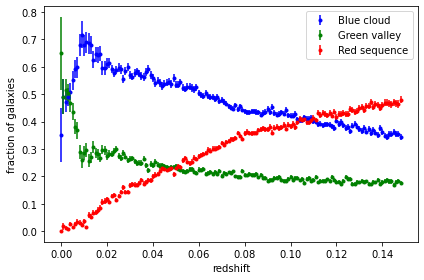

In [177]:
plt.figure(tight_layout=True)

plt.errorbar(z_bins[:-1], BC_frac, yerr=BC_err, fmt='b.', label='Blue cloud')
plt.errorbar(z_bins[:-1], GV_frac, yerr=GV_err, fmt='g.', label='Green valley')
plt.errorbar(z_bins[:-1], RS_frac, yerr=RS_err, fmt='r.', label='Red sequence')

plt.xlabel('redshift')
plt.ylabel('fraction of galaxies')

plt.legend();

Interesting: the red sequence does not exhibit any substantial increase in population around where the surplus of galaxies exist in SDSS ($0.06 \lesssim z \lesssim 0.08$).  Does this imply, then, that this classification is reasonable?  If so, then that means there is a special population of galaxies in the red sequence that have bluer NUV-r colors than normal - why?

# CMDs

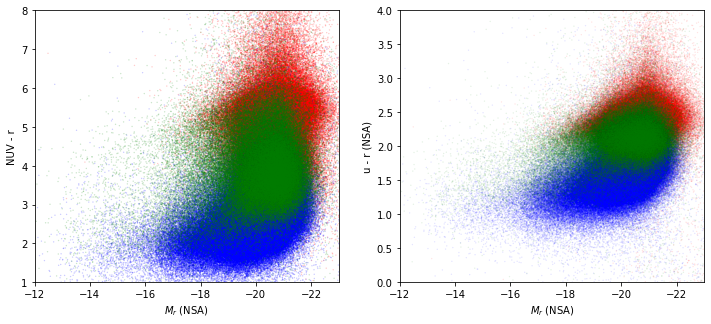

In [118]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['NUV_r'], s=2, c='r', alpha=0.2, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['NUV_r'], s=2, c='b', alpha=0.2, 
            edgecolors='none')
plt.scatter(GV_galaxies['ELPETRO_ABSMAG'][:,4], GV_galaxies['NUV_r'], s=2, c='g', alpha=0.2,
            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('NUV - r')
plt.axis([-12, -23, 1, 8])

plt.subplot(122)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['u_r'], s=2, c='r', alpha=0.1, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['u_r'], s=2, c='b', alpha=0.1, 
            edgecolors='none')
plt.scatter(GV_galaxies['ELPETRO_ABSMAG'][:,4], GV_galaxies['u_r'], s=2, c='g', alpha=0.1,
            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('u - r (NSA)')
plt.axis([-12, -23, 0, 4]);

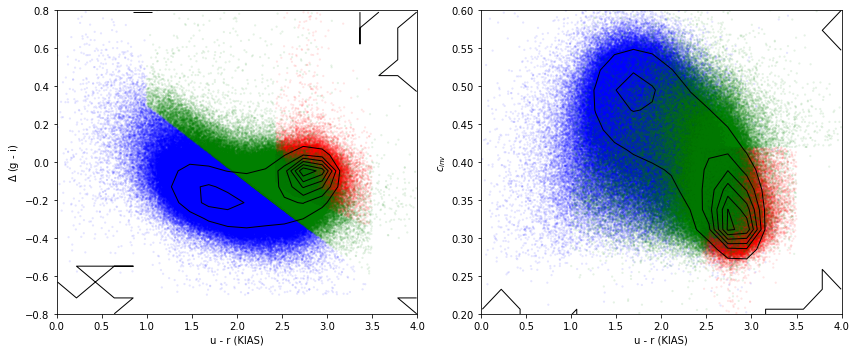

In [120]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'], RS_galaxies['cd'], s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['cd'], s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['cd'], s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'], RS_galaxies['conx1'], s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['conx1'], s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['conx1'], s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.axis([0, 4, 0.2, 0.6]);

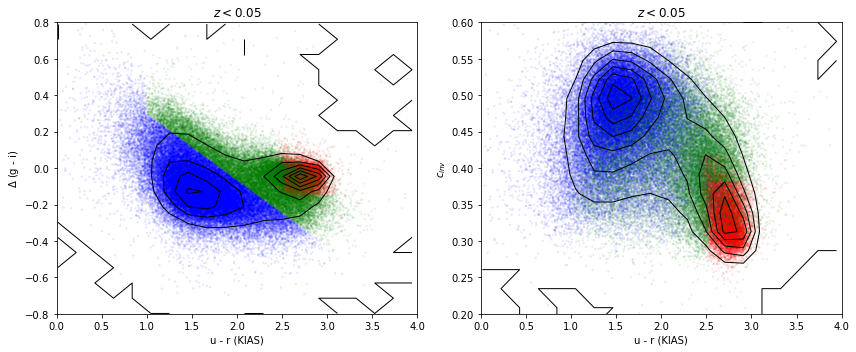

In [121]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] < 0.05))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], 
            RS_galaxies['cd'][RS_galaxies['Z'] < 0.05], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], 
            BC_galaxies['cd'][BC_galaxies['Z'] < 0.05], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], 
            GV_galaxies['cd'][GV_galaxies['Z'] < 0.05], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$z < 0.05$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] < 0.05))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], 
            RS_galaxies['conx1'][RS_galaxies['Z'] < 0.05], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], 
            BC_galaxies['conx1'][BC_galaxies['Z'] < 0.05], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], 
            GV_galaxies['conx1'][GV_galaxies['Z'] < 0.05], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$z < 0.05$')
plt.axis([0, 4, 0.2, 0.6]);

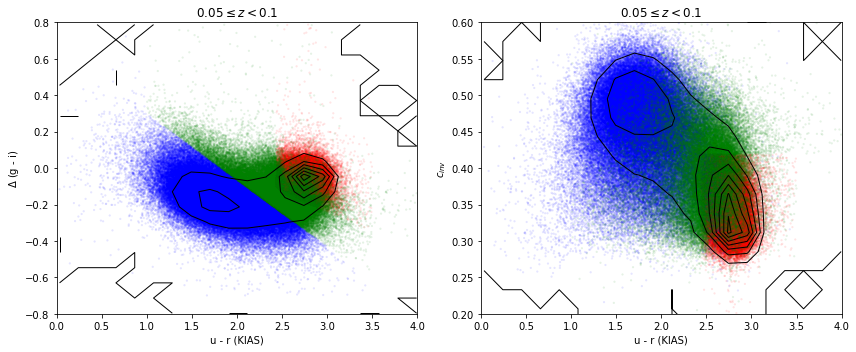

In [122]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] >= 0.05, 
                                                   galaxies['Z'] < 0.1))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            RS_galaxies['cd'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            BC_galaxies['cd'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            GV_galaxies['cd'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$0.05 \leq z < 0.1$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] >= 0.05, 
                                                   galaxies['Z'] < 0.1))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            RS_galaxies['conx1'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            BC_galaxies['conx1'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            GV_galaxies['conx1'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$0.05 \leq z < 0.1$')
plt.axis([0, 4, 0.2, 0.6]);

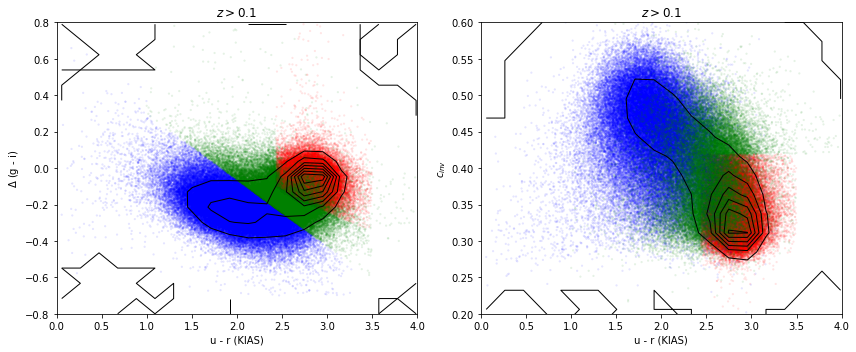

In [123]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] > 0.1))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] > 0.1], 
            RS_galaxies['cd'][RS_galaxies['Z'] > 0.1], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] > 0.1], 
            BC_galaxies['cd'][BC_galaxies['Z'] > 0.1], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] > 0.1], 
            GV_galaxies['cd'][GV_galaxies['Z'] > 0.1], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$z > 0.1$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] > 0.1))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] > 0.1], 
            RS_galaxies['conx1'][RS_galaxies['Z'] > 0.1], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] > 0.1], 
            BC_galaxies['conx1'][BC_galaxies['Z'] > 0.1], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] > 0.1], 
            GV_galaxies['conx1'][GV_galaxies['Z'] > 0.1], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$z > 0.1$')
plt.axis([0, 4, 0.2, 0.6]);

# BPT classifications

Where do these objects sit in the BPT diagrams?

### First, pull in the emission lines necessary for the BPT diagram ([OIII]$\lambda$5007/H$\beta$ and [NII]$\lambda$6583/H$\alpha$)

In [133]:
emline_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_Portsmouth_kadouglass.csv'

emline_table = Table.read(emline_filename, 
                          format='ascii.commented_header', 
                          include_names=['ID', 'Flux_OIII_5006', 'Flux_Hb_4861', 'Flux_NII_6583', 'Flux_Ha_6562'])

In [134]:
emline_table[:5]

ID,Flux_Hb_4861,Flux_OIII_5006,Flux_Ha_6562,Flux_NII_6583
int64,float64,float64,float64,float64
180231,12.74281,4.488409,4.429632,0.0
180229,131.4462,116.5771,244.9139,138.5529
302074,33.93599,9.543151,106.5912,35.90083
180235,21.25503,14.64689,22.40354,3.859374
180237,9.649635,50.19369,36.72042,26.7472


In [138]:
galaxies = join(galaxies, 
                emline_table, 
                keys_left='index', 
                keys_right='ID', 
                join_type='left')

galaxies.remove_column('ID')

In [141]:
RS_galaxies = join(RS_galaxies, 
                   emline_table, 
                   keys_left='index', 
                   keys_right='ID', 
                   join_type='left')

RS_galaxies.remove_column('ID')

In [143]:
GV_galaxies = join(GV_galaxies, 
                   emline_table, 
                   keys_left='index', 
                   keys_right='ID', 
                   join_type='left')

GV_galaxies.remove_column('ID')

In [144]:
BC_galaxies = join(BC_galaxies, 
                   emline_table, 
                   keys_left='index', 
                   keys_right='ID', 
                   join_type='left')

BC_galaxies.remove_column('ID')

### Plot BPT diagram

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/313949249.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/313949249.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/313949249.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/313949249.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']),


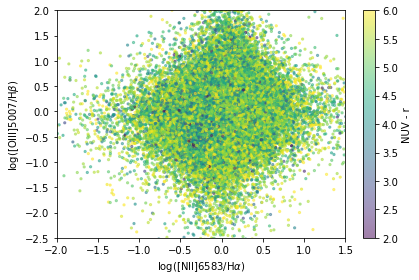

In [164]:
plt.figure(tight_layout=True)

plt.scatter(np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']), 
            np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']), 
            #c='r', 
            c=RS_galaxies['NUV_r'], 
            s=5, 
            alpha=0.5, 
            label='Red sequence')
# plt.plot(np.log10(BC_galaxies['Flux_NII_6583']/BC_galaxies['Flux_Ha_6562']),
#          np.log10(BC_galaxies['Flux_OIII_5006']/BC_galaxies['Flux_Hb_4861']), 
#          'b.', 
#          markersize=1, 
#          alpha=0.1, 
#          label='Blue cloud')
#plt.plot(np.log10(GV_galaxies['Flux_NII_6583']/GV_galaxies['Flux_Ha_6562']), 
#         np.log10(GV_galaxies['Flux_OIII_5006']/GV_galaxies['Flux_Hb_4861']), 
#         'g.', 
#         markersize=1, 
#         alpha=0.1, 
#         label='Green valley')

plt.xlabel(r'log([NII]6583/H$\alpha$)')
plt.ylabel(r'log([OIII]5007/H$\beta$)')

plt.colorbar(label='NUV - r')
plt.clim([2, 6])

plt.xlim([-2, 1.5])
plt.ylim([-2.5, 2]);

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/895848187.py:6: RuntimeWarning: divide by zero encountered in log10
  np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/895848187.py:6: RuntimeWarning: invalid value encountered in log10
  np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/895848187.py:15: RuntimeWarning: divide by zero encountered in log10
  np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']),
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/895848187.py:15: RuntimeWarning: invalid value encountered in log10
  np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']),


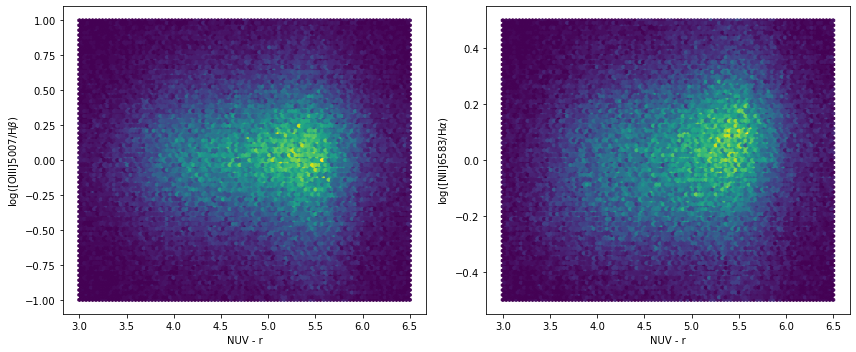

In [170]:
plt.figure(figsize=(12,5), tight_layout=True)


plt.subplot(121)
plt.hexbin(RS_galaxies['NUV_r'], 
           np.log10(RS_galaxies['Flux_OIII_5006']/RS_galaxies['Flux_Hb_4861']), 
           extent=(3, 6.5, -1, 1))

plt.xlabel('NUV - r')
plt.ylabel(r'log([OIII]5007/H$\beta$)')


plt.subplot(122)
plt.hexbin(RS_galaxies['NUV_r'], 
           np.log10(RS_galaxies['Flux_NII_6583']/RS_galaxies['Flux_Ha_6562']), 
           extent=(3, 6.5, -0.5, 0.5))

plt.xlabel('NUV - r')
plt.ylabel(r'log([NII]6583/H$\alpha$)');

# Visually inspect blue bump of RS

In [196]:
# Calculate inverse concentration index using NSA photometry
# Note: KIAS uses R50 and R90 as measured in the i-band
RS_galaxies['cinv_i'] = RS_galaxies['ELPETRO_TH50'][:,5]/RS_galaxies['ELPETRO_TH90'][:,5]
RS_galaxies['cinv_r'] = RS_galaxies['ELPETRO_TH50'][:,4]/RS_galaxies['ELPETRO_TH90'][:,4]

In [205]:
RS_galaxies[['index', 'PLATE', 'MJD', 'FIBERID', 
             'u_r', 'u_r_KIAS', 'NUV_r', 
             'cd', 
             'conx1', 'cinv_i', 'cinv_r',
             'imc', 'aimc', 'my_aimc']][(RS_galaxies['NUV_r'] < 4) & (RS_galaxies['Z'] > 0.05)][9]

index,PLATE,MJD,FIBERID,u_r,u_r_KIAS,NUV_r,cd,conx1,cinv_i,cinv_r,imc,aimc,my_aimc
int64,int32,int32,int16,float64,float64,float64,float64,float64,float32,float32,int64,float64,float64
36857,344,51693,587,3.1620941162109375,2.711,1.5808753967285156,-0.146,0.317,0.30567905,0.2984823,1,1.0,104.60996803725119


# Ageing diagram

(g-r)$_0$ v. EW(H$\alpha$), from https://arxiv.org/abs/2208.14084

## First, pull in the H$\alpha$ EWs

In [226]:
#EW_filename = '/Users/kellydouglass/Documents/Research/data/SDSS/dr7/NSAv101_EW_Portsmouth_kadouglass.csv'
EW_filename = '/Users/kellydouglass/Documents/Research/data/SDSS/dr7/NSAv101_EW_MPAJHU_kadouglass.csv'

EW = Table.read(EW_filename, format='ascii.commented_header', delimiter=',')

In [228]:
EW['Ha_EW'] = EW['h_alpha_flux']/EW['h_alpha_cont']

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/515876852.py:1: RuntimeWarning: divide by zero encountered in true_divide
  EW['Ha_EW'] = EW['h_alpha_flux']/EW['h_alpha_cont']
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_86318/515876852.py:1: RuntimeWarning: invalid value encountered in true_divide
  EW['Ha_EW'] = EW['h_alpha_flux']/EW['h_alpha_cont']


In [ ]:
galaxies = join(galaxies, EW, keys='index')

In [229]:
RS_galaxies = join(RS_galaxies, EW, keys='index')
BC_galaxies = join(BC_galaxies, EW, keys='index')
GV_galaxies = join(GV_galaxies, EW, keys='index')

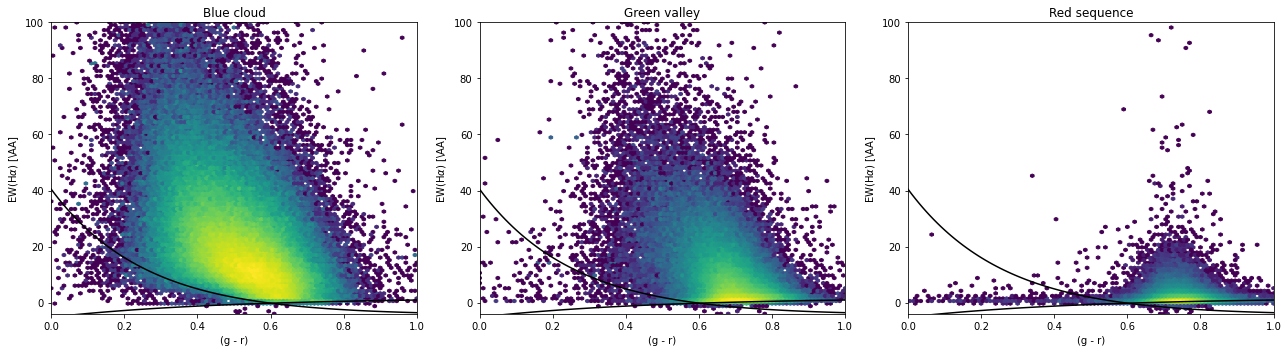

In [230]:
plt.figure(figsize=(18,5), tight_layout=True)

# CorchoCaballero22 ageing diagram lines
x = np.linspace(0, 1, 100)
l1 = 45.0*10**(-1.7*x) - 4.50
l2 = -7.0*10**(-0.9*x) + 1.80


# BC galaxies
plt.subplot(131)
#plt.hexbin(BC_galaxies['g_r'], BC_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(BC_galaxies['g_r'], BC_galaxies['Ha_EW'], extent=(0, 1, -4, 100), bins='log')
plt.plot(x, l1, 'k')
plt.plot(x, l2, 'k')
plt.title('Blue cloud')
plt.xlabel('(g - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]')
plt.xlim([0,1])
plt.ylim([-4, 100])


# GV galaxies
plt.subplot(132)
#plt.hexbin(GV_galaxies['g_r'], GV_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(GV_galaxies['g_r'], GV_galaxies['Ha_EW'], extent=(0, 1, -4, 100), bins='log')
plt.plot(x, l1, 'k')
plt.plot(x, l2, 'k')
plt.title('Green valley')
plt.xlabel('(g - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]')
plt.xlim([0,1])
plt.ylim([-4, 100])


# RS galaxies
plt.subplot(133)
#plt.hexbin(RS_galaxies['g_r'], RS_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(RS_galaxies['g_r'], RS_galaxies['Ha_EW'], extent=(0, 1, -4, 100), bins='log')
plt.plot(x, l1, 'k')
plt.plot(x, l2, 'k')
plt.title('Red sequence')
plt.xlabel('(g - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]')
plt.xlim([0,1])
plt.ylim([-4, 100]);

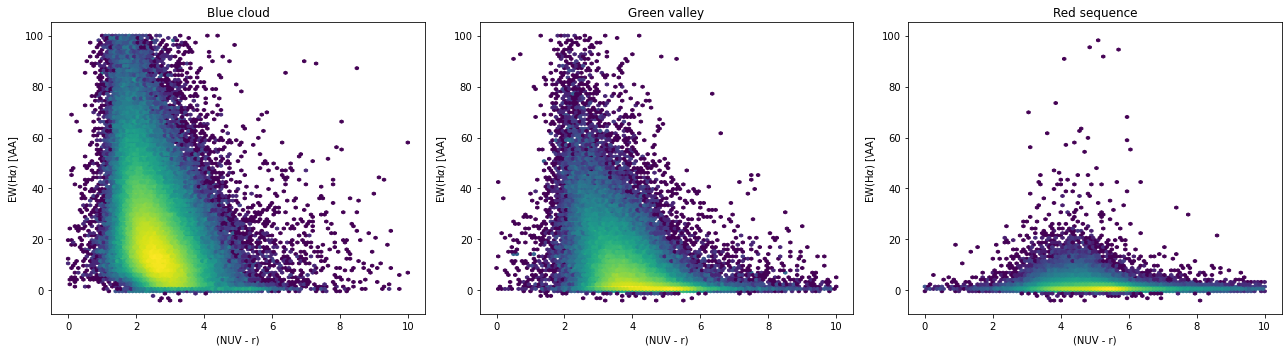

In [231]:
plt.figure(figsize=(18,5), tight_layout=True)


# BC galaxies
plt.subplot(131)
#plt.hexbin(BC_galaxies['g_r'], BC_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(BC_galaxies['NUV_r'], BC_galaxies['Ha_EW'], extent=(0, 10, -4, 100), bins='log')
plt.title('Blue cloud')
plt.xlabel('(NUV - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]')
#plt.xlim([0,10])
#plt.ylim([-4, 100])


# GV galaxies
plt.subplot(132)
#plt.hexbin(GV_galaxies['g_r'], GV_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(GV_galaxies['NUV_r'], GV_galaxies['Ha_EW'], extent=(0, 10, -4, 100), bins='log')
plt.title('Green valley')
plt.xlabel('(NUV - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]')
#plt.xlim([0,1])
#plt.ylim([-4, 100])


# RS galaxies
plt.subplot(133)
#plt.hexbin(RS_galaxies['g_r'], RS_galaxies['EW_Ha_6562'], extent=(0, 1, -4, 100), bins='log')
plt.hexbin(RS_galaxies['NUV_r'], RS_galaxies['Ha_EW'], extent=(0, 10, -4, 100), bins='log')
plt.title('Red sequence')
plt.xlabel('(NUV - r)')
plt.ylabel(r'EW(H$\alpha$) [\AA]');
#plt.xlim([0,1])
#plt.ylim([-4, 100]);